# Some algebra of generators, Brownian movements and showing some features of randomness


Python generators are some interesting beasts. They are vastly more powerful than functions and if you use the send method, they are full on coroutines. However in this post I want to examine a subset of its functionality first and determine the algebraic structures within that subset. 

I am going to examine generators with only using the yield keyword and yield keyword and use the generator expression syntax. Also internal state is allowed. 

E.g.

In [3]:
def fib():
    a = 0
    b = 1 
    while True:
        yield a
        t = (a + b)
        a = b 
        b = t

Because generators often won't stop producing data, they can be streams, infinite lists. We need some tools to properly observe them. For now observe, take and drop are enough.

In [7]:
def repeat(n):
    while True:
        yield n
        
def observe(n,gen):
    return list(next(gen) for _ in range (0,n))

def take(n, gen):
    yield from (next(gen) for _ in range(0,n))

def drop(n,gen):
    for _ in range(0,n):
        next(gen)
    yield from (next(gen) for _ in repeat(None))
        

In [43]:
list(take(10,fib()))

[0, 1, 1, 2, 3, 5, 8, 13, 21]

In [42]:
observe(10,take(10,fib())) == observe(10, fib())

True

In [ ]:
observe(10,drop(10,fib()))

Now we have these, lets explore generators a bit more. I would like to show it are free monoids. 
A monoid is a algebraic structure with the following properties: 

It has a set *M*. An operation *(+)* that can add members of *M* together and will yield a new element of *M* and a special member *e* of *M* called unit. 

Further more the operation (+) is closed, that means that for every two members of *M* we get a new element of *M* and never go outside of *M*. 

Let's write down some rules for the monoid (a and b are members of M):

a + (b + c) = (a + b) + b (associativity)
a + e = e + a = a  (identity)

And certain monoids are commutative:

a + b = b + a (commutativity)

if a,b are members of M then so is a+b (closure)

Examples of monoids are the natural numbers, lists of elements and void in programming languages.

Then there is a special monoid, that can turn every set S of objects into a monoid. This is called the Free monoid. 

Lists are free monoids. We can lift all objects of set S in a list like so: 

M* = { List(x) for every x in S }

Now it is not a monoid yet, because we lack the structure. For example the above set M* misses the unit. So let's create that. First we tack on the empty list:

M = M* U { List() } 

List concatenation will be our operation. 

It is not hard to show this indeed follow the rules, but I am not going to do that here. 

So that is nice, we can turn every set of objects into an monoid. That is why it is called free!

However to do something useful with this, we need to interpret this. That will come later.

## Generators can simulate lists

It is easy to show that every list can be a generator, but not every generator is a list, at least in python. If we allow infinite lists, the notions come closer together. 


In [8]:
def listToGenerator(lst):
    for i in lst:
        yield i 

observe(3,listToGenerator([1,2,3,4]))

[1, 2, 3]

And to show there are generators that are not lists (in python): 

In [ ]:
def nonListGenerator():
    while True:
        yield 1

list(nonListGenerator())

The above program will never finish. 

# Brownian motion

Brownian motion is the random movement we observe in a gas. It comes from the energy in each particle and its interactions with others. Wikipedia has a nice picture of this: 


![Brownian motion](https://upload.wikimedia.org/wikipedia/commons/5/51/Brownianmotion5particles150frame.gif)

We can simulate a discrete version of this by taking a random source, transforming it outputs into directions and applying these to a particle.

Let's call this the random taxicab ride, to honor the [taxicab metric](https://en.wikipedia.org/wiki/Taxicab_geometry). And we are going to define it with generators as free monoids and some utilities we will write to visualize our taxi. 

The goal is to get a stream of positions of our cab. Lets build this.
First we import some utilities:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import default_rng


Then we need to think about the movements of our cab. How many degrees of freedom does it have? I count 4. It can go left, right, up and down. And lets also tack on doing nothing. So we want a stream that generate a random stream of {1,2,3,4}'s

In [20]:
def cabDirections():
    rng = default_rng()
    while True:
        yield rng.integers(1,5)

In [21]:
observe(10,cabDirections())

[3, 2, 1, 2, 2, 2, 1, 4, 2, 2]

Nice that works!
Now we need to model our taxi. We can imagine it runs on an infinite grid of integer positions and the taxi itself has a position. So a reasonable model of our taxi would be this:

$$ taxi = \pmatrix{x \\ y} $$

Just its position. For the movement we need to map every direction into a vector: 

$$L = \pmatrix{-1 \\ 0}$$
$$R = \pmatrix{1 \\ 0}$$
$$U = \pmatrix{0 \\ 1}$$
$$D = \pmatrix{0 \\ -1}$$

And we can define a distance as follow:
$$d(a,b) = |a_1 - b_1| + |a_2 - b_2|$$

That is the distance the taxi should travel to go from point a to b. 

We can easily show that the taxi can travel everywhere combining the above vectors, given a random position (x,y):

$$\pmatrix{x\\y} = x \pmatrix{1 \\ 0} + y  \pmatrix{0 \\ 1}$$


We also define the taxi can only do one step at a time. Now write this in code:

In [23]:
def gmap(f,gen):
    yield from (f(x) for x in gen)
# map directions to a vector
def dirToVec(x):
    if x == 1: # L 
        return np.array([-1,0])
    if x == 2: # R
        return np.array([1,0])
    if x == 3: # U
        return np.array([0,1])
    if x == 4: # D
        return np.array([0,-1])
    
def taxiMovements():
    yield from gmap(dirToVec,cabDirections()) 
    
    
observe(10, taxiMovements())    

[array([1, 0]),
 array([1, 0]),
 array([1, 0]),
 array([ 0, -1]),
 array([0, 1]),
 array([1, 0]),
 array([-1,  0]),
 array([1, 0]),
 array([-1,  0]),
 array([1, 0])]

Nice, we build some up some nice vocabulary and show that generators are Endofunctors by writing a map function for it. 

Now we need a generator that takes in the above generator and maps it into a stream  of positions of the taxi. This generator takes in a start position and then generates the positions. 


In [31]:
def fold(f,s,g):
    for x in g:
        s = f(s,x)
        yield s
        
def taxi(pos = np.array([0,0])):
    yield from fold(lambda current_pos,direction: np.add(current_pos,direction),pos,taxiMovements())

In [32]:
observe(10,taxi())

[array([-1,  0]),
 array([-2,  0]),
 array([-2,  1]),
 array([-3,  1]),
 array([-3,  0]),
 array([-2,  0]),
 array([-1,  0]),
 array([-1, -1]),
 array([ 0, -1]),
 array([ 0, -2])]

In [ ]:
Nice, now we can plot how our taxi moves:

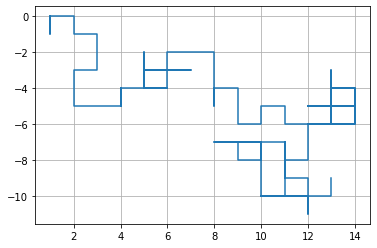

In [41]:

def observeArray(n,g):
    return np.array(n, g)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.grid()
x,y = observeArray(100,taxi()).T
plt.plot(x,y)

In [ ]:
Or a bit more fancy, we can see what places our random taxi frequents the most: 

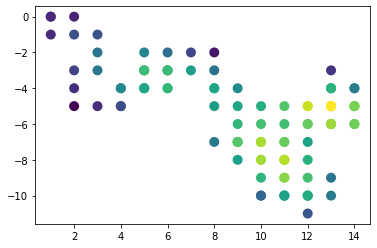

In [45]:
from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
